# Trotterized Hubbard

Bloqs implementing Trotterized unitary evolution under the Hubbard Hamiltonian.

The Hubbard model is given as a sum of two terms

$$
H = H_h + H_I
$$

where the hopping hamiltonian is given as 
$$
H_h = -\tau \sum_{\langle p, q\rangle, \sigma} 
    \left(a_{p\sigma}^{\dagger} a_{q\sigma} + \mathrm{h.c.} \right)
$$
where the sum is over nearest neighbour lattice sites (under periodic boundary conditions).

Following the [reference](https://arxiv.org/abs/2012.09238) we assume the
shifted form of the interacting Hamiltonian:
$$
H_I = \frac{u}{4} \sum_{p} z_{p\uparrow}z_{p\downarrow}
$$
where $z_{p\sigma} = (2 n_{p\sigma} - 1)$.


For Trotterization we assume the plaquette splitting from the
[reference](https://arxiv.org/abs/2012.09238).
The plaquette splitting rewrites $H_h$ as a sum of $H_h^p$ and $H_h^g$ (for pink and gold
respectively) which when combined tile the entire lattice. Each plaquette
contains four sites and paritions the lattice such that each edge of the lattice
belongs to a single plaquette. Each term within a grouping commutes so that the
unitary can be be implemented as
$$
e^{i H_h^{x}} = \prod_{k\sigma} e^{i H_h^{x(k,\sigma)}}
$$
without further trotter error.

In [1]:
from qualtran import Bloq, CompositeBloq, BloqBuilder, Signature, Register
from qualtran import QBit, QInt, QUInt, QAny
from qualtran.drawing import show_bloq, show_call_graph, show_counts_sigma
from typing import *
import numpy as np
import sympy
import cirq

## `HoppingTile`
Bloq implementing a "tile" of the one-body hopping unitary.

Implements the unitary
$$
e^{i H_h^{x}} = \prod_{k\sigma} e^{i t H_h^{x(k,\sigma)}}
$$
for a particular choise of of plaquette hamiltonian $H_h^x$, where $x$ = pink or gold.

#### Parameters
 - `length`: Lattice side length L.
 - `angle`: The prefactor scaling the Hopping hamiltonian in the unitary (`t` above). This should contain any relevant prefactors including the time step and any splitting coefficients.
 - `tau`: The Hopping hamiltonian parameter. Typically the hubbard model is defined relative to $\tau$ so it's defaulted to 1.
 - `eps`: The precision of the single qubit rotations.
 - `pink`: The colour of the plaquette. 

#### Registers
 - `system`: The system register of size 2 `length`. 

#### References
 - [Early fault-tolerant simulations of the Hubbard model](https://arxiv.org/abs/2012.09238). see Eq. 21 and App E.


In [2]:
from qualtran.bloqs.chemistry.trotter.hubbard.hopping import HoppingTile

### Example Instances

In [3]:
length = 8
angle = 0.5
hopping_tile = HoppingTile(length, angle)

#### Graphical Signature

In [4]:
from qualtran.drawing import show_bloqs
show_bloqs([hopping_tile],
           ['`hopping_tile`'])

### Call Graph

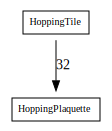

#### Counts totals:
 - `HoppingPlaquette`: 32

In [5]:
from qualtran.resource_counting.generalizers import ignore_split_join
hopping_tile_g, hopping_tile_sigma = hopping_tile.call_graph(max_depth=1, generalizer=ignore_split_join)
show_call_graph(hopping_tile_g)
show_counts_sigma(hopping_tile_sigma)

## `HoppingPlaquette`
A bloq implementing a single plaquette unitary.

The bloq implements
$$
    e^{i \kappa R_\mathrm{plaq}}
$$
where $\tau R^{k\sigma}_\mathrm{plaq} = H_h^{x(k,\sigma)}$, i.e. R is
non-zero only in the subploq relevant for the particular indexed plaquette.

The plaquette operator is given by
$$
    \sum_{i,j} [R_{\mathrm{plaq}}]_{i,j} a_{i\sigma}^\dagger a_{j\sigma}
$$
where the non-zero sub-bloq of $R_{\mathrm{plaq}}$ is

$$
    R_{\mathrm{plaq}} =
    \begin{bmatrix}
        0 & 1 & 0 & 1 \\
        1 & 0 & 1 & 0 \\
        0 & 1 & 0 & 1 \\
        1 & 0 & 1 & 0
    \end{bmatrix}
$$

#### Parameters
 - `kappa`: The scalar prefactor appearing in the definition of the unitary. Usually a combination of the timestep and the hopping parameter $\tau$.
 - `eps`: The precision of the single qubit rotations. 

#### Registers
 - `qubits`: A register of four qubits this unitary should act on. 

#### References
 - [Early fault-tolerant simulations of the Hubbard model](https://arxiv.org/abs/2012.09238). page 13 Eq. E4 and E5 (Appendix E)


In [6]:
from qualtran.bloqs.chemistry.trotter.hubbard.hopping import HoppingPlaquette

### Example Instances

In [7]:
length = 8
angle = 0.15
plaquette = HoppingPlaquette(length, angle)

#### Graphical Signature

In [8]:
from qualtran.drawing import show_bloqs
show_bloqs([plaquette],
           ['`plaquette`'])

### Call Graph

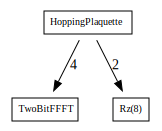

#### Counts totals:
 - `Rz(8)`: 2
 - `TwoBitFFFT`: 4

In [9]:
from qualtran.resource_counting.generalizers import ignore_split_join
plaquette_g, plaquette_sigma = plaquette.call_graph(max_depth=1, generalizer=ignore_split_join)
show_call_graph(plaquette_g)
show_counts_sigma(plaquette_sigma)

## `Interaction`
Bloq implementing the hubbard U part of the hamiltonian.

Specifically:
$$
    U_I = e^{i t H_I}
$$
which can be implemented using equal angle single-qubit Z rotations.

#### Parameters
 - `length`: Lattice length $L$.
 - `angle`: The prefactor scaling the Hopping hamiltonian in the unitary (`t` above). This should contain any relevant prefactors including the time step and any splitting coefficients.
 - `hubb_u`: The hubbard $U$ parameter.
 - `eps`: The precision of the single qubit rotations. 

#### Registers
 - `system`: The system register of size 2 `length`. 

#### References
 - [Early fault-tolerant simulations of the Hubbard model](https://arxiv.org/abs/2012.09238). Eq. 6 page 2 and page 13 paragraph 1.


In [10]:
from qualtran.bloqs.chemistry.trotter.hubbard.interaction import Interaction

### Example Instances

In [11]:
length = 8
angle = 0.5
hubb_u = 4.0
interaction = Interaction(length, angle, hubb_u)

#### Graphical Signature

In [12]:
from qualtran.drawing import show_bloqs
show_bloqs([interaction],
           ['`interaction`'])

### Call Graph

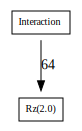

#### Counts totals:
 - `Rz(2.0)`: 64

In [13]:
from qualtran.resource_counting.generalizers import ignore_split_join
interaction_g, interaction_sigma = interaction.call_graph(max_depth=1, generalizer=ignore_split_join)
show_call_graph(interaction_g)
show_counts_sigma(interaction_sigma)

## `HoppingTileHWP`
Bloq implementing a "tile" of the one-body hopping unitary using Hamming weight phasing.

Implements the unitary
$$
e^{i H_h^{x}} = \prod_{k\sigma} e^{i t H_h^{x(k,\sigma)}}
$$
for a particular choise of of plaquette hamiltonian $H_h^x$, where $x$ = pink or gold.

Each plaquette Hamiltonian can be split into $L^2/4$ commuting terms. Each
term can be implemented using the 4-qubit HoppingPlaquette above. The
HoppingPlaquette bloq contains 2 arbitrary rotations which are flanked by Clifford operations.
All of the rotations within a HoppingTile have the same angle so we can use
HammingWeightPhaseing to reduce the number of T gates that need to be
synthesized. Accounting for spin there are then $2 \times 2 \times L^2/4$
arbitrary rotations in each Tile, but only  $L^2/2$ of them can be applied
at the same time due to the $e^{iXX} e^{iYY}$ circuit not permitting parallel $R_z$ gates.

Unlike in the HoppingTile implementation where we can neatly factor
everything into sub-bloqs, here we would need to apply any clifford and F
gates first in parallel then bulk apply the rotations in parallel using
HammingWeightPhasing and then apply another layer of clifford and F gates.

#### Parameters
 - `length`: Lattice side length L.
 - `angle`: The prefactor scaling the Hopping hamiltonian in the unitary (`t` above). This should contain any relevant prefactors including the time step and any splitting coefficients.
 - `tau`: The Hopping hamiltonian parameter. Typically the hubbard model is defined relative to $\tau$ so it's defaulted to 1.
 - `eps`: The precision of the single qubit rotations.
 - `pink`: The colour of the plaquette. 

#### Registers
 - `system`: The system register of size 2 `length`. 

#### References
 - [Early fault-tolerant simulations of the Hubbard model](https://arxiv.org/abs/2012.09238). Eq. 21 and App E.


In [14]:
from qualtran.bloqs.chemistry.trotter.hubbard.hopping import HoppingTileHWP

### Example Instances

In [15]:
length = 8
angle = 0.15
hopping_tile_hwp = HoppingTileHWP(length, angle)

#### Graphical Signature

In [16]:
from qualtran.drawing import show_bloqs
show_bloqs([hopping_tile_hwp],
           ['`hopping_tile_hwp`'])

### Call Graph

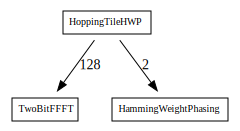

#### Counts totals:
 - `HammingWeightPhasing`: 2
 - `TwoBitFFFT`: 128

In [17]:
from qualtran.resource_counting.generalizers import ignore_split_join
hopping_tile_hwp_g, hopping_tile_hwp_sigma = hopping_tile_hwp.call_graph(max_depth=1, generalizer=ignore_split_join)
show_call_graph(hopping_tile_hwp_g)
show_counts_sigma(hopping_tile_hwp_sigma)

## `InteractionHWP`
Bloq implementing the hubbard U part of the hamiltonian using Hamming weight phasing.

Specifically:
$$
    U_I = e^{i t H_I}
$$
which can be implemented using equal angle single-qubit Z rotations.

Each interaction term can be implemented using a e^{iZZ} gate, which
decomposes into a single Rz gate flanked by cliffords. There are L^2
equal angle rotations in total all of which may be applied in parallel using HWP.

#### Parameters
 - `length`: Lattice length L.
 - `angle`: The rotation angle for unitary.
 - `hubb_u`: The hubbard U parameter.
 - `eps`: The precision for single qubit rotations. 

#### Registers
 - `system`: The system register of size 2 `length`. 

#### References
 - [Early fault-tolerant simulations of the Hubbard model](https://arxiv.org/abs/2012.09238). Eq. page 13 paragraph 1, and page 14 paragraph 3 right column. They apply 2 batches of $L^2/2$ rotations.


In [18]:
from qualtran.bloqs.chemistry.trotter.hubbard.interaction import InteractionHWP

### Example Instances

In [19]:
length = 8
angle = 0.52728
hubb_u = 4.0
interaction_hwp = InteractionHWP(length, angle, hubb_u)

#### Graphical Signature

In [20]:
from qualtran.drawing import show_bloqs
show_bloqs([interaction_hwp],
           ['`interaction_hwp`'])

### Call Graph

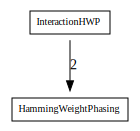

#### Counts totals:
 - `HammingWeightPhasing`: 2

In [21]:
from qualtran.resource_counting.generalizers import ignore_split_join
interaction_hwp_g, interaction_hwp_sigma = interaction_hwp.call_graph(max_depth=1, generalizer=ignore_split_join)
show_call_graph(interaction_hwp_g)
show_counts_sigma(interaction_hwp_sigma)